Requires the dependencies in environment-verification.yml and that you have run DownloadData.ipynb.

# Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
plt.rc('figure', figsize=(21,7))

# Definitions

In [2]:
def diagref(**kwargs):
    plt.plot(*[plt.xlim()]*2, 'k--', zorder=-1)

def mae_info_planar(data=None, add_count=False, add_relative=False, **kwargs):
    text = f'MAE\n${1000*data.dE_defect_norm_model.mean():.2f}\,\mathrm{{meV/\AA}}^2$\n'
    if add_relative:
        text += f'${100*data.dE_defect_model_rel.mean():.2f}\,\%$'
    plt.text(.33, .7, text, transform=plt.gca().transAxes, ha='center')
    if add_count:
        plt.text(.66, .2, f'# {len(data)}', ha='center', transform=plt.gca().transAxes)

def mae_info_point(data=None, add_count=True, **kwargs):
    plt.text(.33, .7, 
         f'MAE\n${1000*data.dE_defect_model.mean():.2f}\,\mathrm{{meV}}$\n', 
         transform=plt.gca().transAxes, 
         ha='center')
    if add_count:
        plt.text(.66, .2, f'# {len(data)}', ha='center', transform=plt.gca().transAxes)

from scipy.spatial import ConvexHull

def get_convex(df, c, f, return_idx=False):
    dd = df.query(f'{f} <= 0')
    hull = ConvexHull(dd[[c, f]].to_numpy())
    points = hull.points[hull.vertices]
    points = points[np.argsort(points[:, 0])] # sort by concentration
    if not return_idx:
        return points.T
    else:
        return points.T, dd.index[hull.vertices]

def plot_binary_convex_hull(df, sharey=False, potential_name='MTP', model_name='DFT',
                            elements=['Al','Ca','Mg'],
                            label_structures=True):
    ylim = df[['E_formation', 'E_formation_model']].min(axis=None) * 1.2, df[['E_formation', 'E_formation_model']].max(axis=None) * 1.2
    for i, el in enumerate(elements):
        plt.subplot(1, len(elements), i+1)
        c = f'c_{elements[(i+1)%len(elements)]}'
        clabel = f'$c_\mathrm{{{elements[(i+1)%len(elements)]}}}$'
        ee = elements.copy()
        ee.remove(el)
        plt.title(''.join(sorted(ee)))
        dd = df.query(f'{el}==0')
        plt.plot(*get_convex(dd, c, 'E_formation'))
        plt.plot(*get_convex(dd, c, 'E_formation_model'))
        kwargs = {}
        if label_structures:
            kwargs['style'] = 'structure'
        t = sns.scatterplot(
            data=dd.rename({'E_formation': potential_name, 'E_formation_model': model_name}, axis='columns').melt(
                id_vars=[c,'structure'], 
                value_vars=[potential_name, model_name],
                var_name='model'
            ),
            x=c, y='value',
            hue='model', 
            s=200, alpha=.75,
            **kwargs
        )
        if sharey:
            plt.ylim(*ylim)
        plt.ylabel('$E_f$ [eV/atom]')
        plt.xlabel(clabel)
    plt.tight_layout()
    return t

<>:5: SyntaxWarning: invalid escape sequence '\,'
<>:5: SyntaxWarning: invalid escape sequence '\A'
<>:7: SyntaxWarning: invalid escape sequence '\,'
<>:14: SyntaxWarning: invalid escape sequence '\,'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\,'
<>:5: SyntaxWarning: invalid escape sequence '\A'
<>:7: SyntaxWarning: invalid escape sequence '\,'
<>:14: SyntaxWarning: invalid escape sequence '\,'
<>:39: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_27212/3731592772.py:5: SyntaxWarning: invalid escape sequence '\,'
  text = f'MAE\n${1000*data.dE_defect_norm_model.mean():.2f}\,\mathrm{{meV/\AA}}^2$\n'
/tmp/ipykernel_27212/3731592772.py:5: SyntaxWarning: invalid escape sequence '\A'
  text = f'MAE\n${1000*data.dE_defect_norm_model.mean():.2f}\,\mathrm{{meV/\AA}}^2$\n'
/tmp/ipykernel_27212/3731592772.py:7: SyntaxWarning: invalid escape sequence '\,'
  text += f'${100*data.dE_defect_model_rel.mean():.2f}\,\%$'
/tmp/ipykernel_

# Plots

All the tables here have data for eight different potentials, the one discussed in the publication can be filtered for by `level==24 and rmax==8.2`, see below.

## Bulk

In [3]:
bulk = pd.read_csv('Data/Bulk/Bulk.csv', index_col=0)

In [4]:
bulk = bulk.query('level==24 and rmax==8.2')

<Axes: title={'center': 'AlCa'}, xlabel='$c_\\mathrm{Al}$', ylabel='$E_f$ [eV/atom]'>

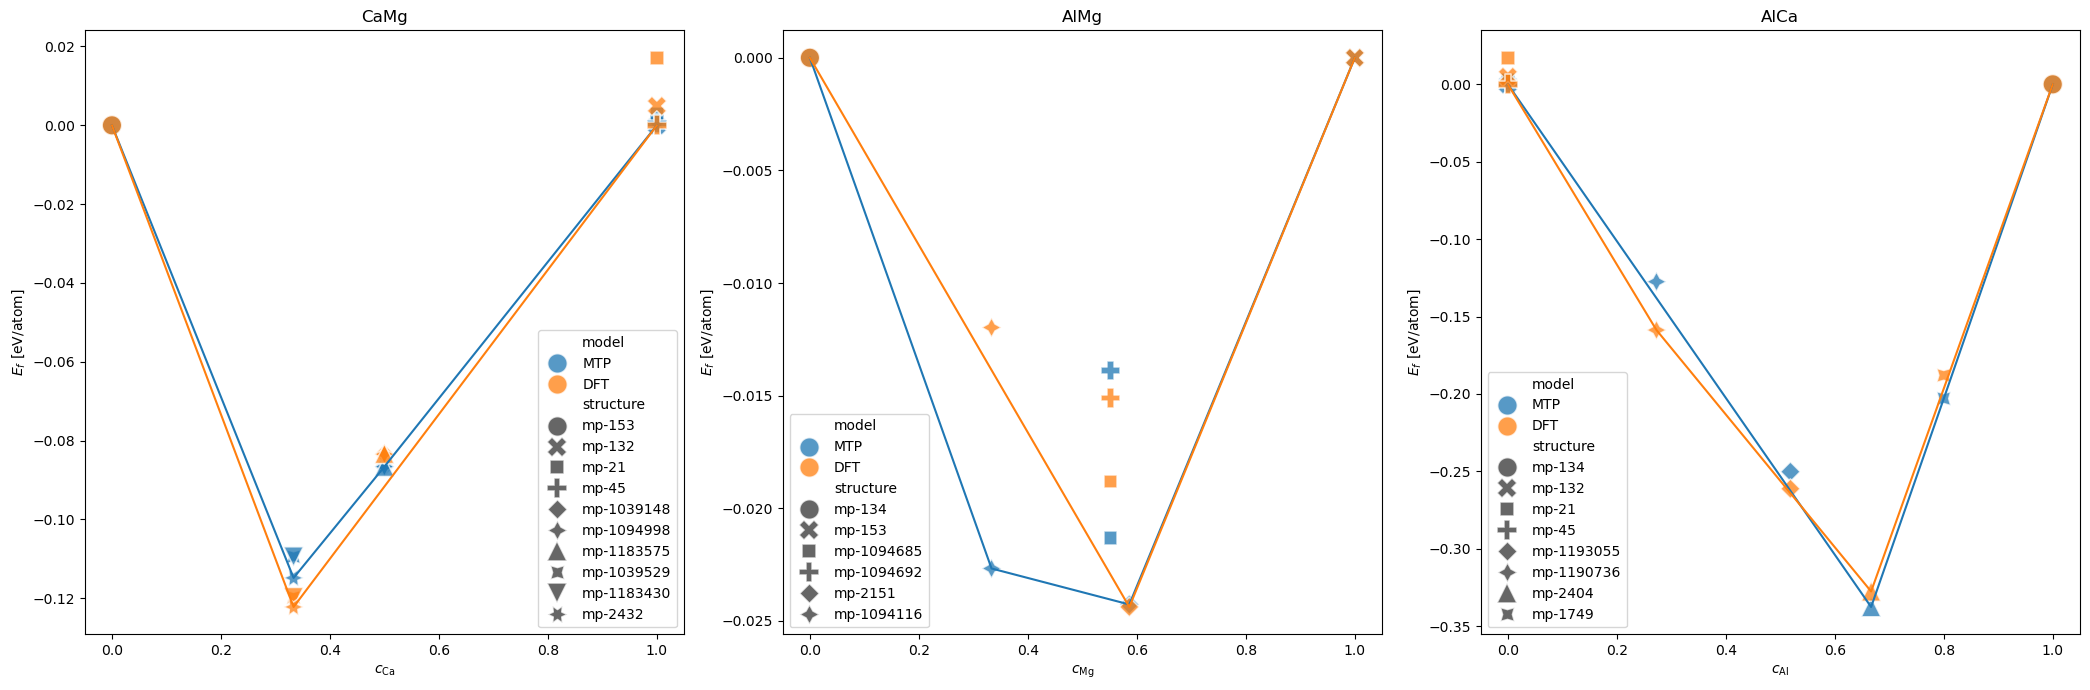

In [5]:
plot_binary_convex_hull(bulk)

## Volume

In [6]:
vol = pd.read_csv('Data/Volume/Volume.csv', index_col=0).query('level==24 and rmax==8.2')

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_27212/1318513051.py:12: SyntaxWarning: invalid escape sequence '\m'
  xlabel='$V$ [$\mathrm{\AA}^3$/atom]',


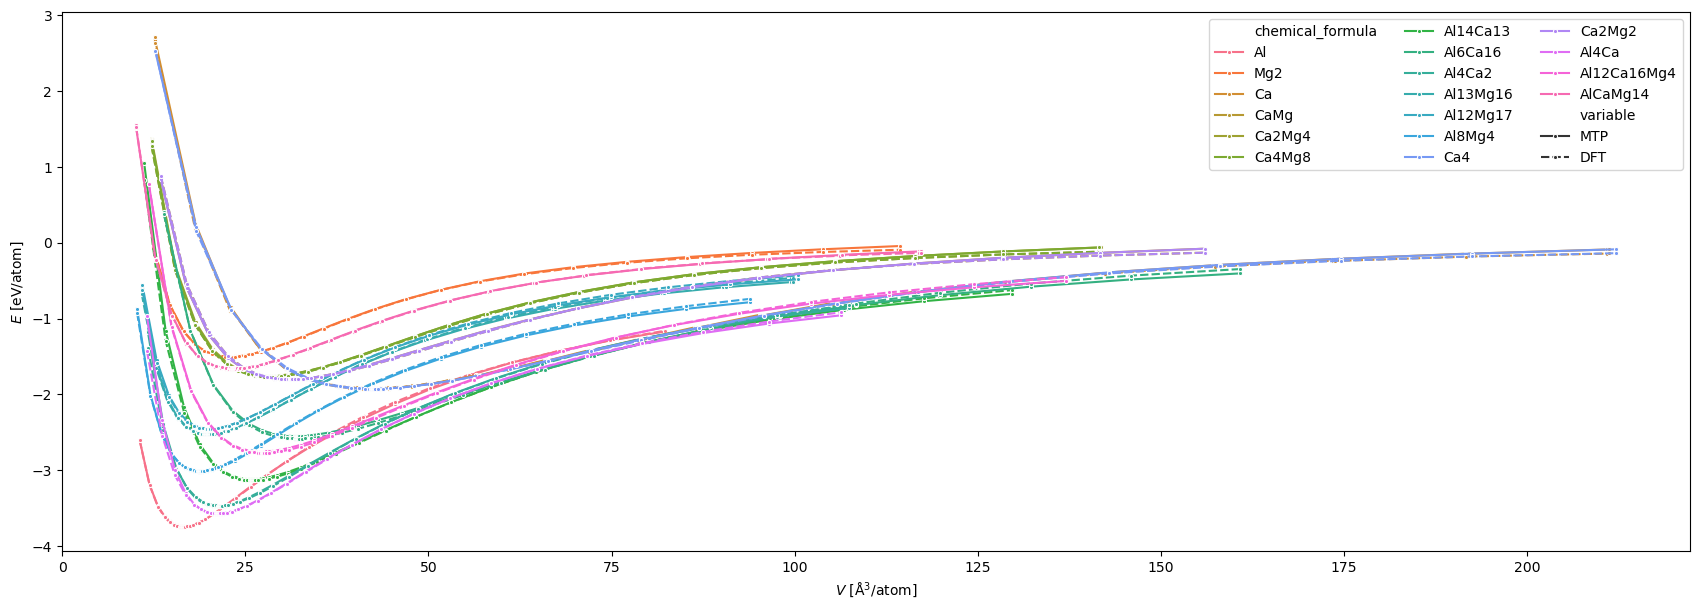

In [7]:
g = sns.lineplot(
    data=vol.melt(
        value_vars=['E', 'E_model'],
        id_vars=['V','chemical_formula','structure','level','rmax', 'name']
    ).replace({'E': 'MTP', 'E_model': 'DFT'}), 
    marker='.',
    x='V', y='value',
    hue='chemical_formula',
    style='variable',
    units='name', estimator=None,
).set(
    xlabel='$V$ [$\mathrm{\AA}^3$/atom]',
    ylabel='$E$ [eV/atom]',
)
plt.legend(ncols=3)

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_27212/4175477089.py:12: SyntaxWarning: invalid escape sequence '\m'
  xlabel='$V$ [$\mathrm{\AA}^3$/atom]',


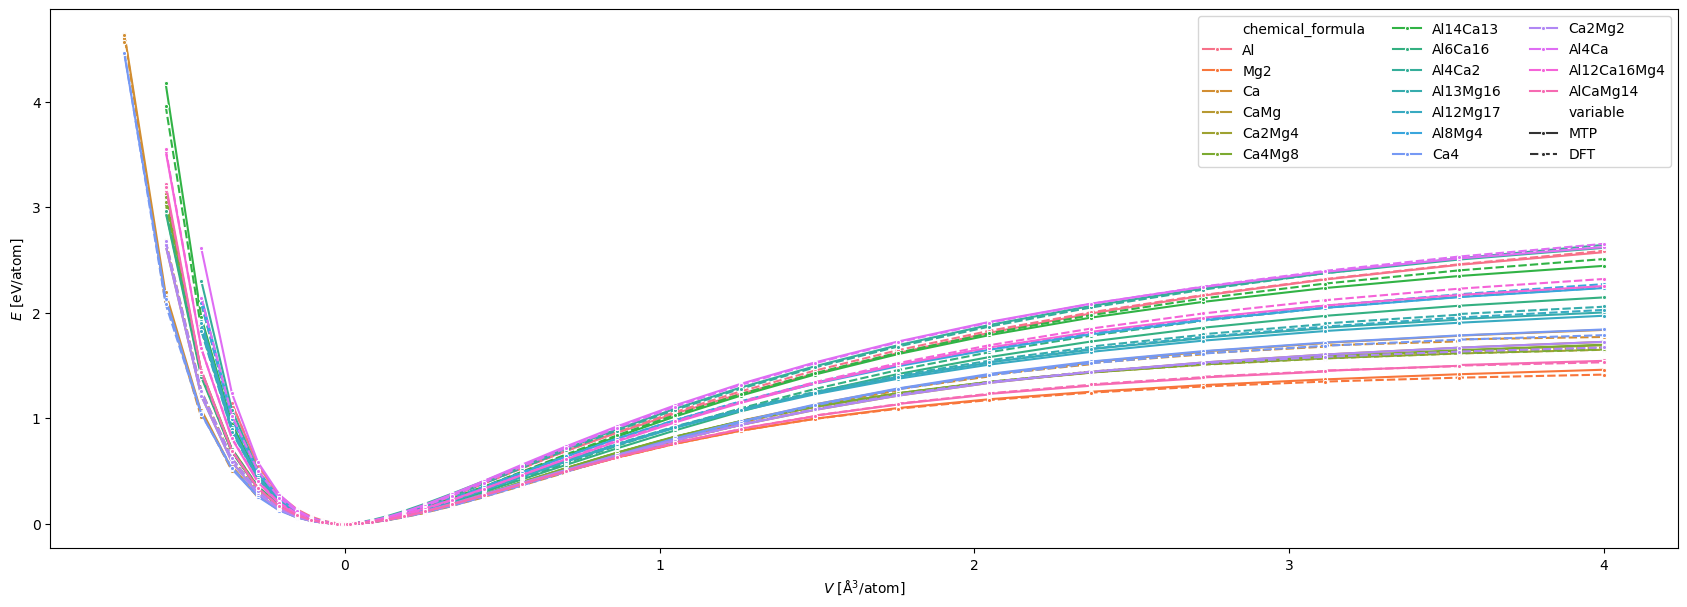

In [8]:
g = sns.lineplot(
    data=vol.melt(
        value_vars=['E_strain', 'E_strain_model'],
        id_vars=['strain', 'set_strain', 'V','chemical_formula','structure','level','rmax', 'name']
    ).replace({'E_strain': 'MTP', 'E_strain_model': 'DFT'}), 
    marker='.',
    x='set_strain', y='value',
    hue='chemical_formula',
    style='variable',
    units='name', estimator=None,
).set(
    xlabel='$V$ [$\mathrm{\AA}^3$/atom]',
    ylabel='$E$ [eV/atom]',
)
plt.legend(ncols=3)

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_27212/3855155329.py:12: SyntaxWarning: invalid escape sequence '\m'
  xlabel='$V$ [$\mathrm{\AA}^3$/atom]',


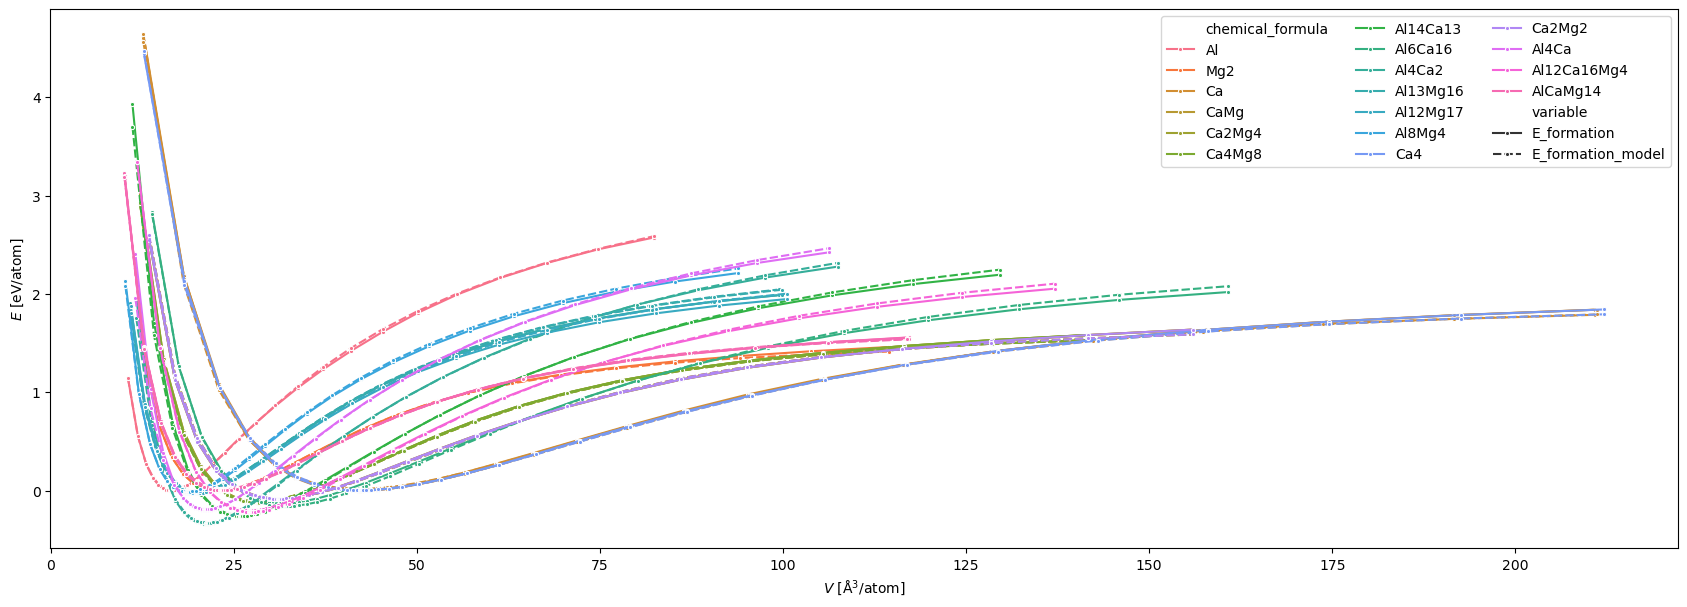

In [9]:
g = sns.lineplot(
    data=vol.melt(
        value_vars=['E_formation', 'E_formation_model'],
        id_vars=['V','chemical_formula','structure','level','rmax', 'name']
    ).replace({'E': 'MTP', 'E_model': 'DFT'}), 
    marker='.',
    x='V', y='value',
    hue='chemical_formula',
    style='variable',
    units='structure', estimator=None,
).set(
    xlabel='$V$ [$\mathrm{\AA}^3$/atom]',
    ylabel='$E$ [eV/atom]',
)
plt.legend(ncols=3)

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_27212/3516753229.py:11: SyntaxWarning: invalid escape sequence '\m'
  xlabel='$V$ [$\mathrm{\AA}^3$/atom]',


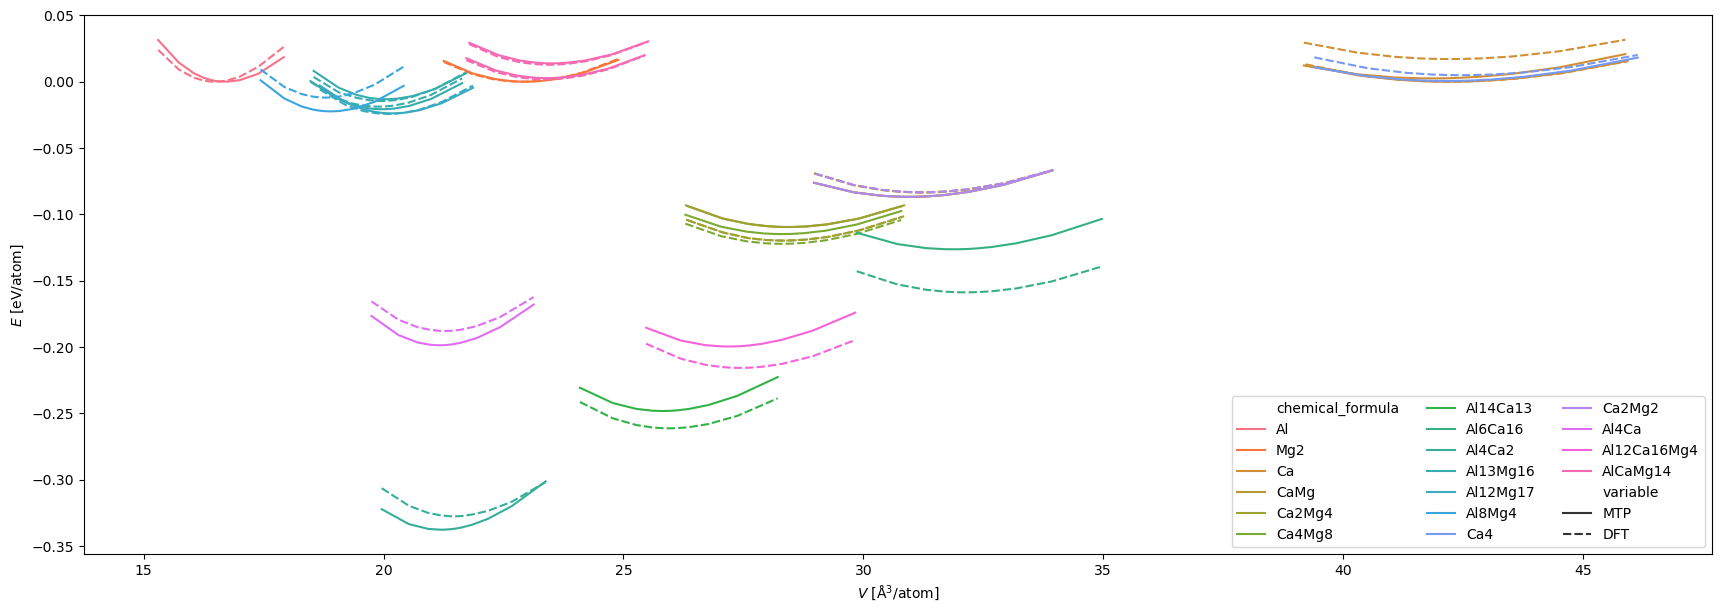

In [10]:
g = sns.lineplot(
    data=vol.query('abs(set_strain)<.1').melt(
        value_vars=['E_formation', 'E_formation_model'],
        id_vars=['V','chemical_formula','structure','level','rmax', 'name']
    ).replace({'E_formation': 'MTP', 'E_formation_model': 'DFT'}), 
    x='V', y='value',
    hue='chemical_formula',
    style='variable',
    units='structure', estimator=None,
).set(
    xlabel='$V$ [$\mathrm{\AA}^3$/atom]',
    ylabel='$E$ [eV/atom]',
)
plt.legend(ncols=3)

## Surfaces

In [11]:
surf = pd.read_csv("Data/Surfaces/Surfaces.csv", index_col=0).query('level==24 and rmax==8.2')

In [12]:
# renaming things to legibility
surf.reference = surf.reference.replace(
    {'mp-153': 'Mg (hcp)', 'mp-45': 'Ca (fcc)', 'mp-134': 'Al (fcc)'}
)
surf.rename({'reference': 'host'}, axis='columns', inplace=True)

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_27212/1890688329.py:13: SyntaxWarning: invalid escape sequence '\m'
  xlabel='$E_\mathrm{DFT}$ [eV/$\mathrm{\AA}^2$]',
/tmp/ipykernel_27212/1890688329.py:14: SyntaxWarning: invalid escape sequence '\m'
  ylabel='$E_\mathrm{MTP}$ [eV/$\mathrm{\AA}^2$]',


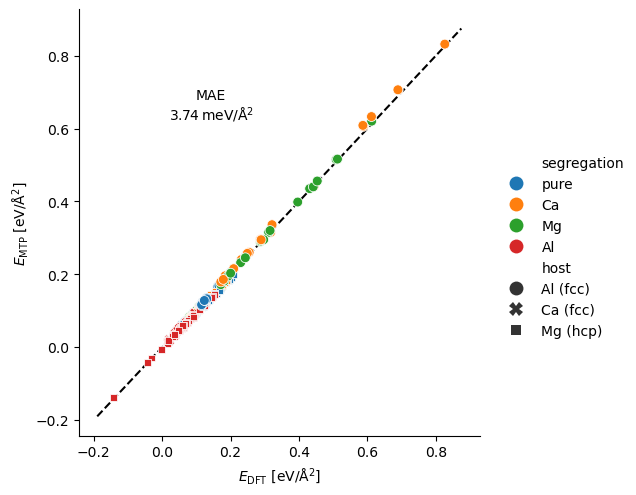

In [13]:
g = sns.relplot(
    data=surf,
    x='E_defect_norm_model', y='E_defect_norm',
    hue='segregation',
    style='host',
    s=50,
    # alpha=.5
).map(
    diagref
).map_dataframe(
    mae_info_planar
).set(
    xlabel='$E_\mathrm{DFT}$ [eV/$\mathrm{\AA}^2$]',
    ylabel='$E_\mathrm{MTP}$ [eV/$\mathrm{\AA}^2$]',
)
for lh in g.legend.legend_handles:
    lh.set_markersize(10)

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_27212/826224918.py:13: SyntaxWarning: invalid escape sequence '\m'
  xlabel='$E_\mathrm{DFT}$ [eV/$\mathrm{\AA}^2$]',
/tmp/ipykernel_27212/826224918.py:14: SyntaxWarning: invalid escape sequence '\m'
  ylabel='$E_\mathrm{MTP}$ [eV/$\mathrm{\AA}^2$]',


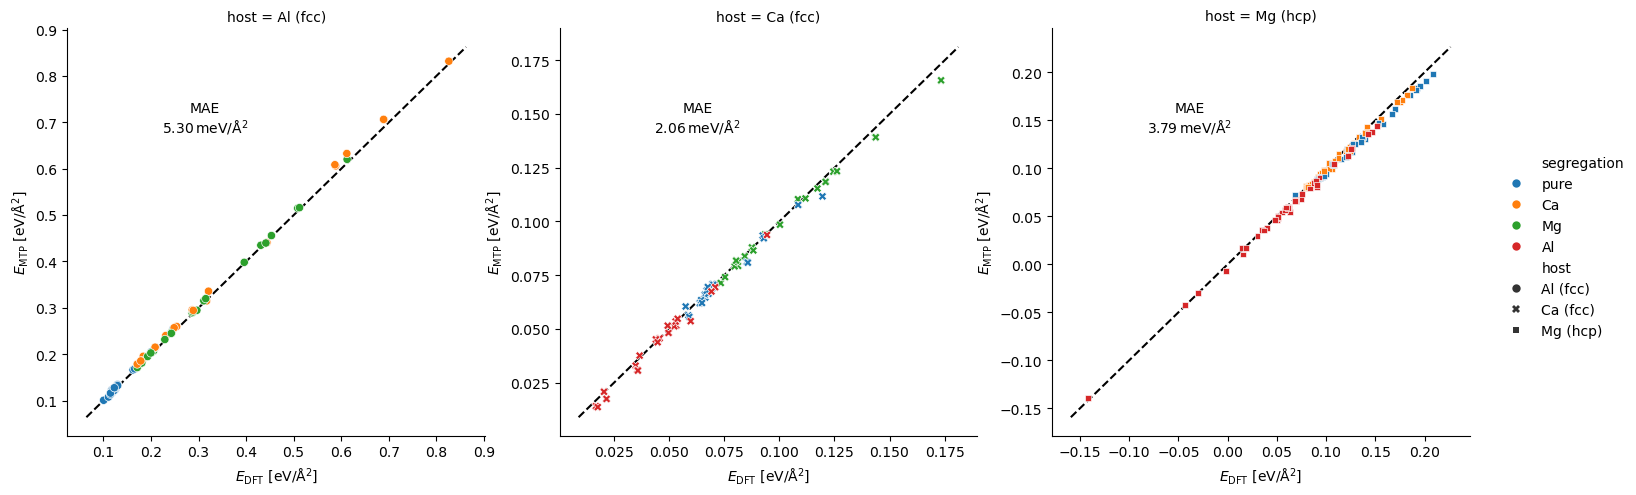

In [14]:
g = sns.relplot(
    data=surf,
    x='E_defect_norm_model', y='E_defect_norm',
    hue='segregation',
    style='host',
    col='host',
    facet_kws={'sharey': False, 'sharex': False},
).map(
    diagref
).map_dataframe(
    mae_info_planar
).set(
    xlabel='$E_\mathrm{DFT}$ [eV/$\mathrm{\AA}^2$]',
    ylabel='$E_\mathrm{MTP}$ [eV/$\mathrm{\AA}^2$]',
)

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_27212/4270040936.py:14: SyntaxWarning: invalid escape sequence '\m'
  xlabel='$E_\mathrm{DFT}$ [eV/$\mathrm{\AA}^2$]',
/tmp/ipykernel_27212/4270040936.py:15: SyntaxWarning: invalid escape sequence '\m'
  ylabel='$E_\mathrm{MTP}$ [eV/$\mathrm{\AA}^2$]',


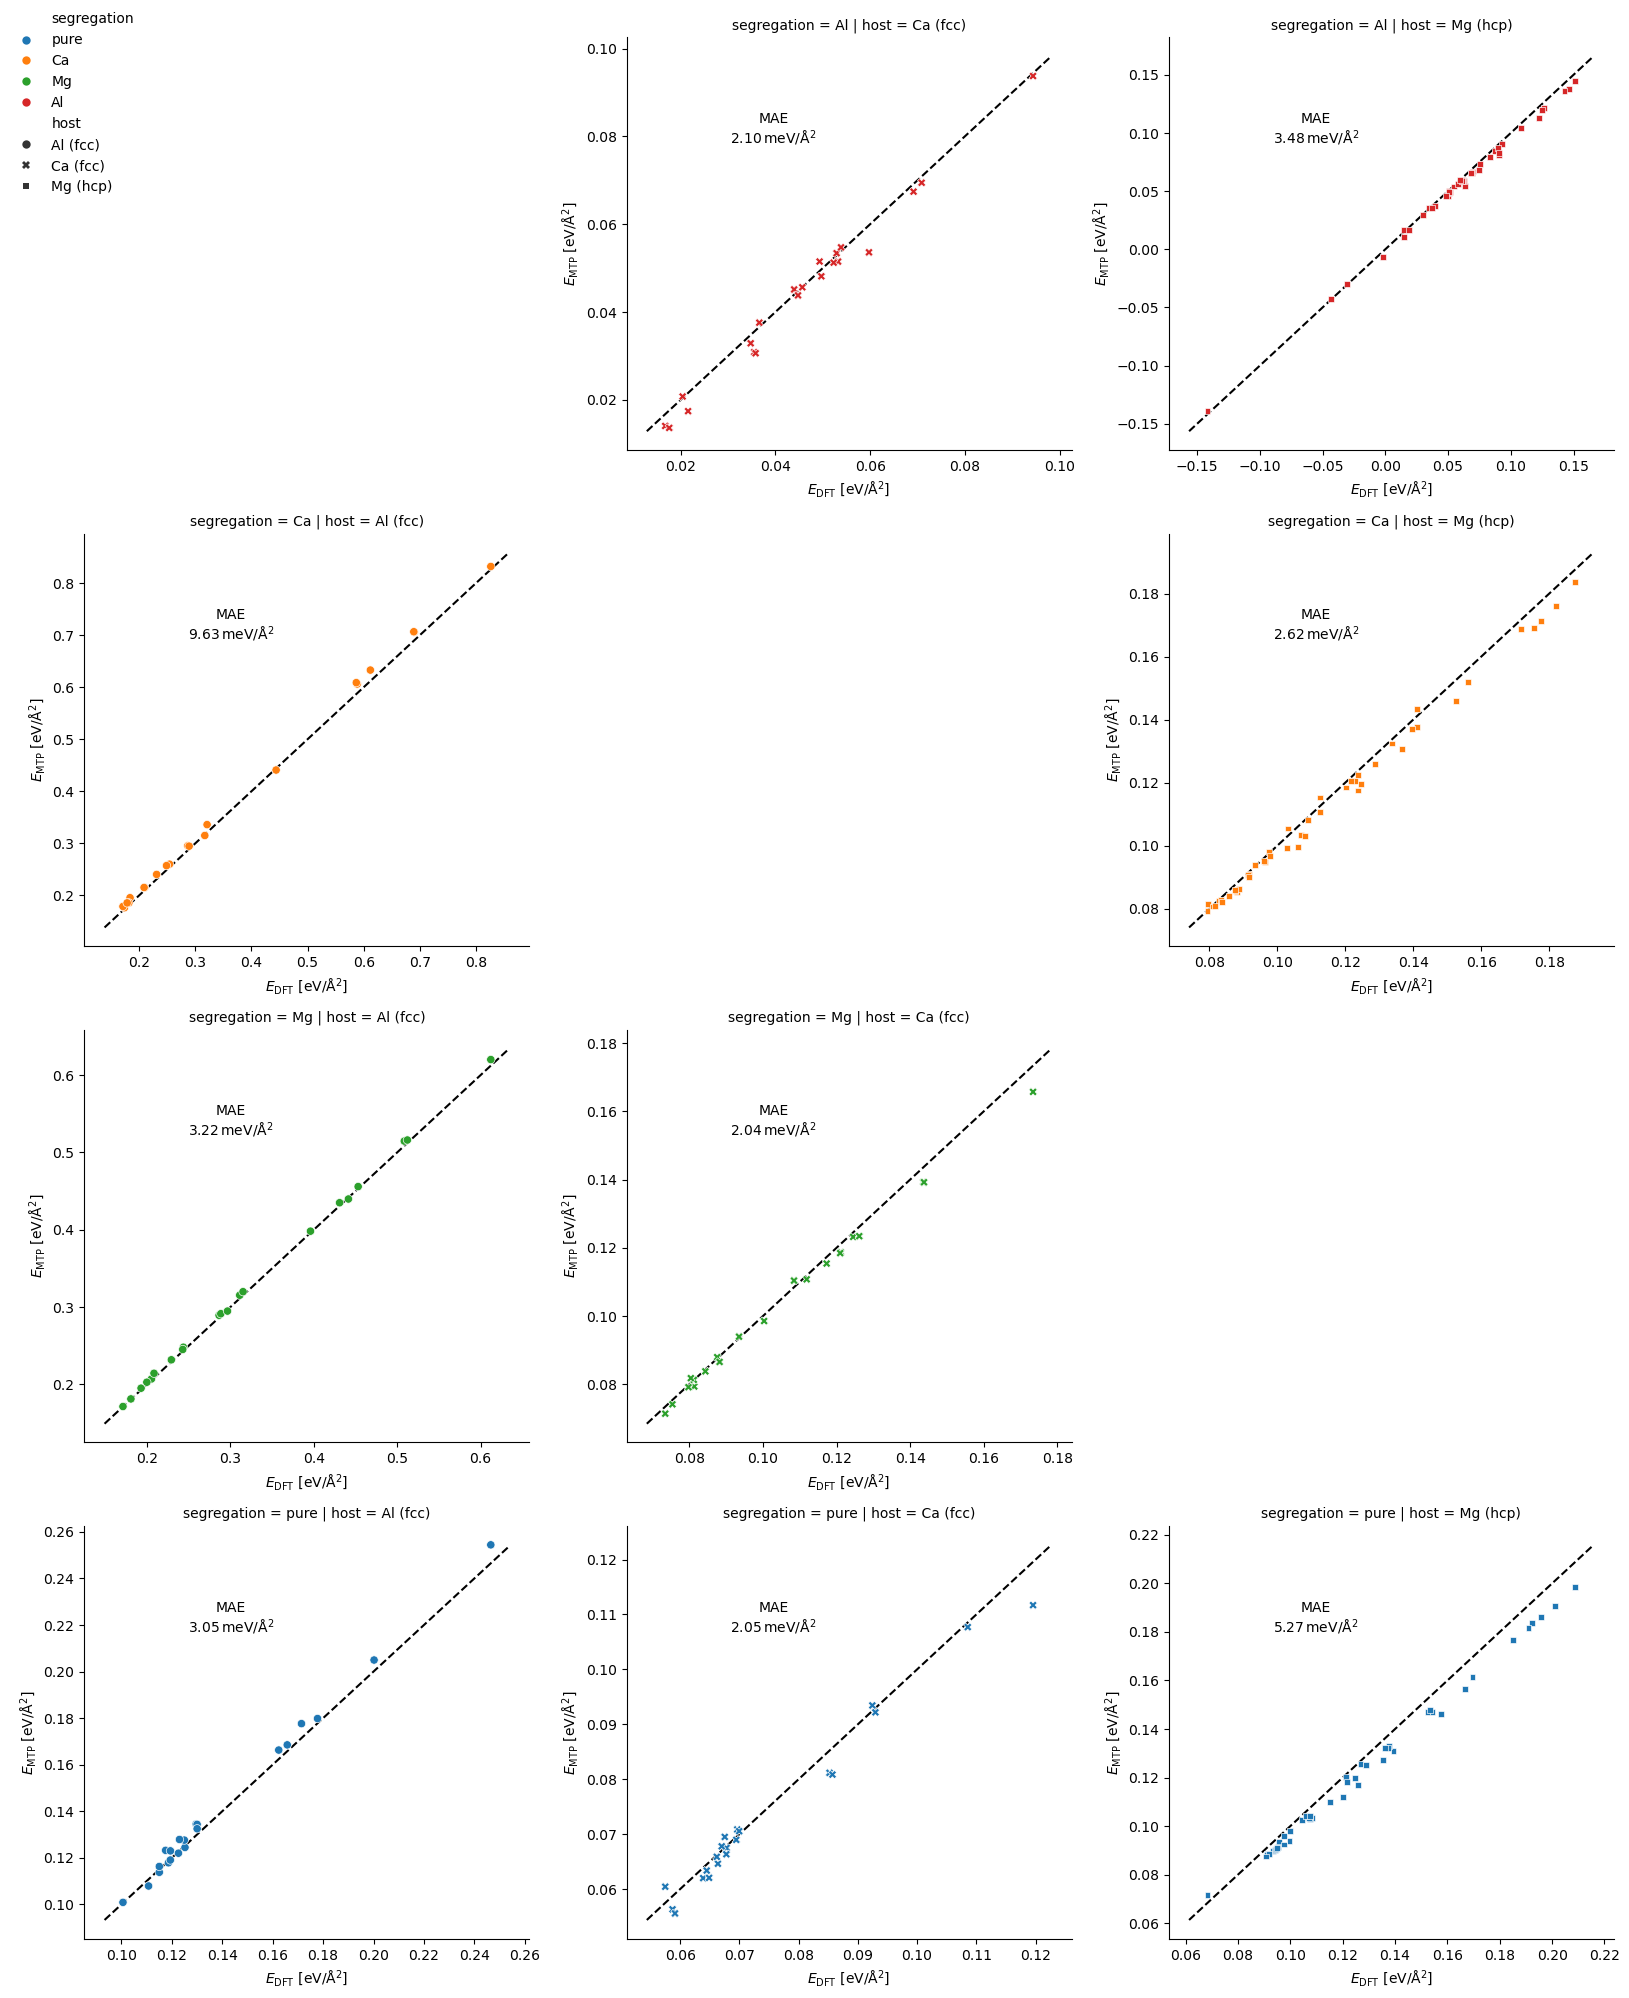

In [15]:
g = sns.relplot(
    data=surf,
    x='E_defect_norm_model', y='E_defect_norm',
    hue='segregation',
    style='host',
    col='host', col_order=np.sort(surf.host.unique()),
    row='segregation', row_order=np.sort(surf.segregation.unique()),
    facet_kws={'sharey': False, 'sharex': False},
).map(
    diagref
).map_dataframe(
    mae_info_planar
).set(
    xlabel='$E_\mathrm{DFT}$ [eV/$\mathrm{\AA}^2$]',
    ylabel='$E_\mathrm{MTP}$ [eV/$\mathrm{\AA}^2$]',
)
g.axes_dict['Ca', 'Ca (fcc)'].clear()
g.axes_dict['Ca', 'Ca (fcc)'].set_axis_off()
g.axes_dict['Al', 'Al (fcc)'].clear()
g.axes_dict['Al', 'Al (fcc)'].set_axis_off()
g.axes_dict['Mg', 'Mg (hcp)'].clear()
g.axes_dict['Mg', 'Mg (hcp)'].set_axis_off()
plt.tight_layout()
sns.move_legend(g, loc='upper left')

## Grain Boundary

In [16]:
gb = pd.read_csv("Data/GBs/GBs.csv", index_col=0).query('level==24 and rmax==8.2')

In [17]:
# renaming things to legibility
gb.reference = gb.reference.replace(
    {'mp-153': 'Mg (hcp)', 'mp-45': 'Ca (fcc)', 'mp-134': 'Al (fcc)'}
)
gb.rename({'reference': 'host'}, axis='columns', inplace=True)

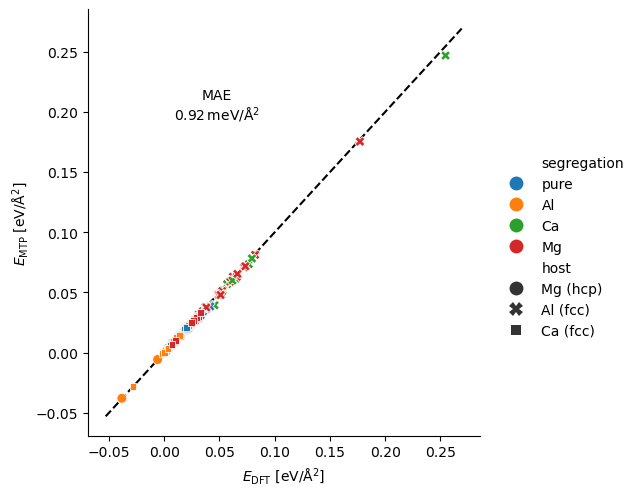

In [23]:
g = sns.relplot(
    data=gb,
    x='E_defect_norm_model', y='E_defect_norm',
    hue='segregation',
    style='host',
    s=50,
).map(
    diagref
).map_dataframe(
    mae_info_planar
).set(
    xlabel=r'$E_\mathrm{DFT}$ [eV/$\mathrm{\AA}^2$]',
    ylabel=r'$E_\mathrm{MTP}$ [eV/$\mathrm{\AA}^2$]',
)
for lh in g.legend.legend_handles:
    lh.set_markersize(10)

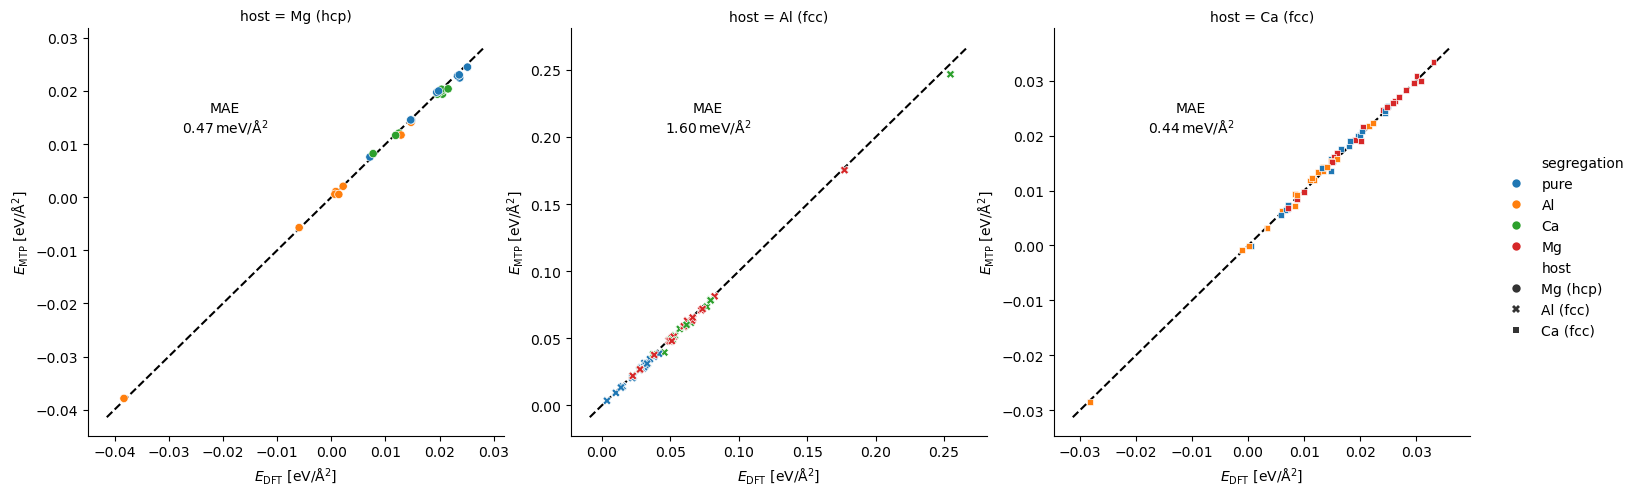

In [24]:
g = sns.relplot(
    data=gb,
    x='E_defect_norm_model', y='E_defect_norm',
    hue='segregation',
    style='host',
    col='host',
    facet_kws={'sharey': False, 'sharex': False},
).map(
    diagref
).map_dataframe(
    mae_info_planar
).set(
    xlabel=r'$E_\mathrm{DFT}$ [eV/$\mathrm{\AA}^2$]',
    ylabel=r'$E_\mathrm{MTP}$ [eV/$\mathrm{\AA}^2$]',
)

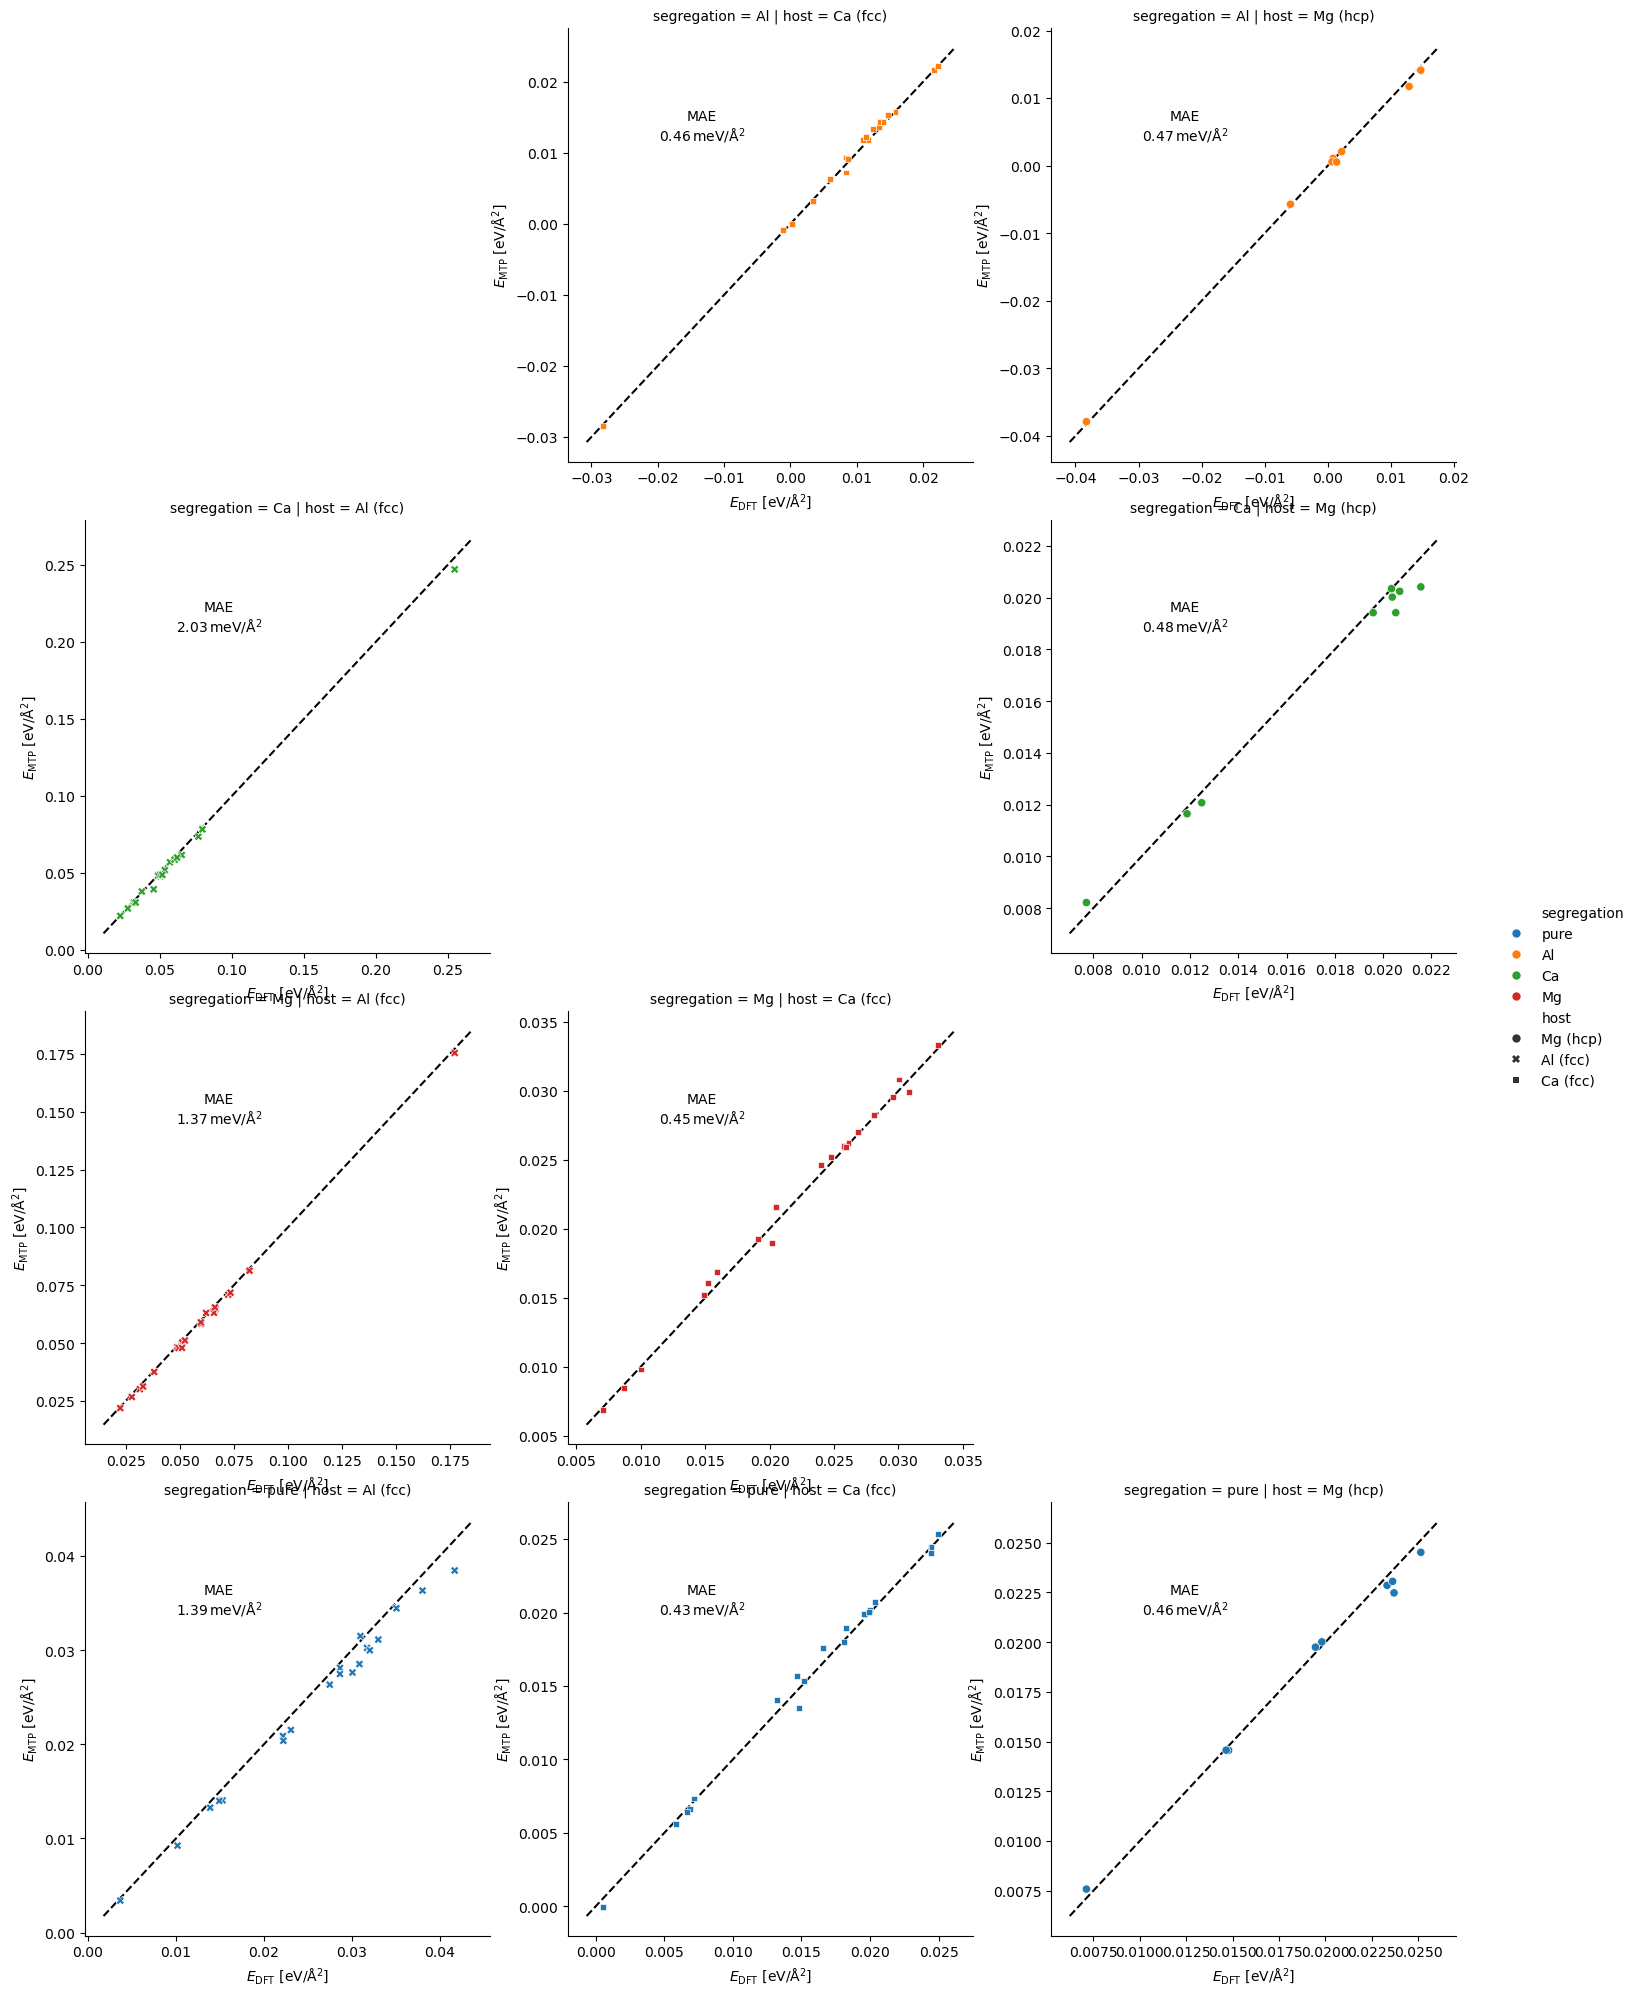

In [25]:
g = sns.relplot(
    data=gb,
    x='E_defect_norm_model', y='E_defect_norm',
    hue='segregation',
    style='host',
    col='host', col_order=np.sort(gb.host.unique()),
    row='segregation', row_order=np.sort(gb.segregation.unique()),
    facet_kws={'sharey': False, 'sharex': False},
).map(
    diagref
).map_dataframe(
    mae_info_planar
).set(
    xlabel=r'$E_\mathrm{DFT}$ [eV/$\mathrm{\AA}^2$]',
    ylabel=r'$E_\mathrm{MTP}$ [eV/$\mathrm{\AA}^2$]',
)
g.axes_dict['Ca', 'Ca (fcc)'].clear()
g.axes_dict['Ca', 'Ca (fcc)'].set_axis_off()
g.axes_dict['Al', 'Al (fcc)'].clear()
g.axes_dict['Al', 'Al (fcc)'].set_axis_off()
g.axes_dict['Mg', 'Mg (hcp)'].clear()
g.axes_dict['Mg', 'Mg (hcp)'].set_axis_off()

## Phase Diagrams

In [21]:
mgal = pd.read_csv("Data/PhaseDiagrams/MgAl/phasediagram.csv", index_col=0)

<Axes: xlabel='c', ylabel='T'>

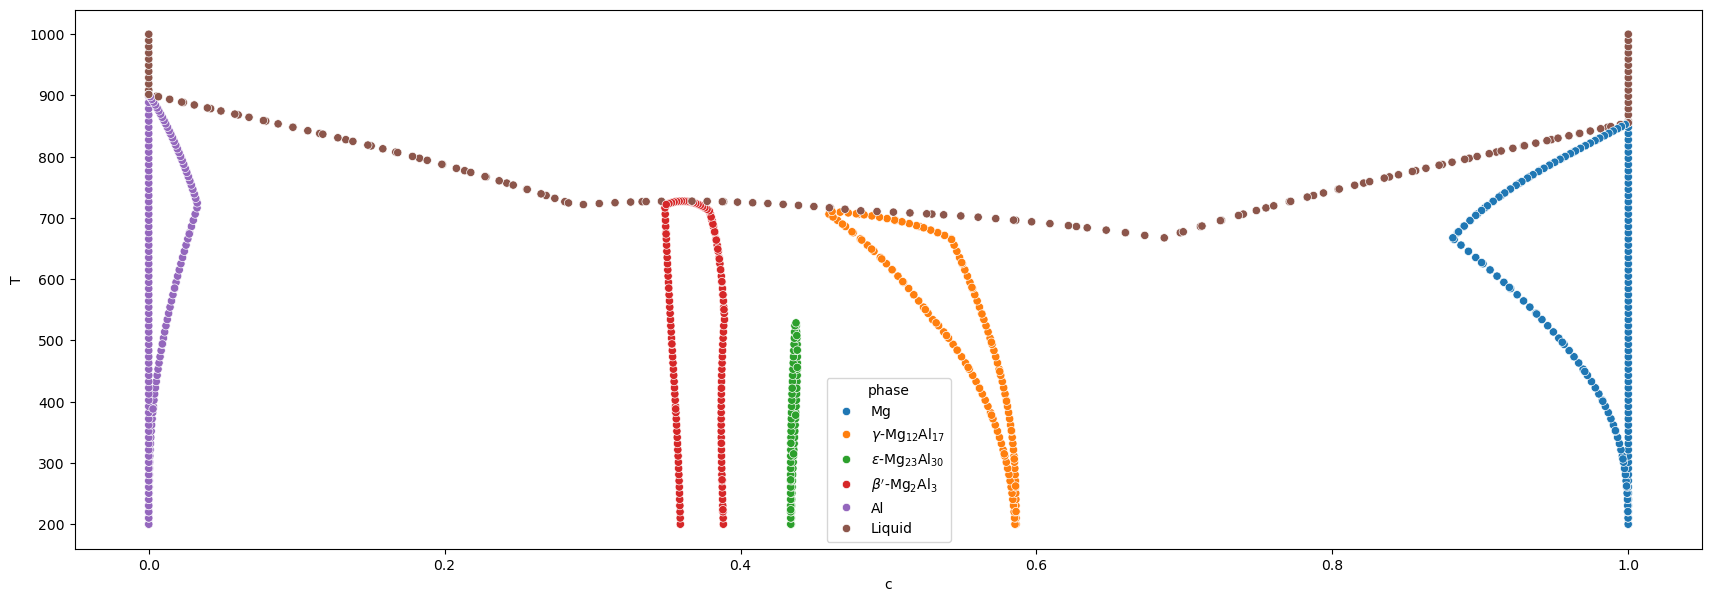

In [22]:
sns.scatterplot(
    data=mgal.query('border'),
    x='c', y='T',
    hue='phase'
)